In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
# creating test, dev, train files
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
#MLP 
n_embed = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483547)
C = torch.randn((vocab_size , n_embed), generator =g) #27,10
W1 = torch.randn((n_embed*block_size, n_hidden), generator = g) *0.2
b1 = torch.randn(n_hidden, generator = g)*0.01
W2 = torch.randn((n_hidden, vocab_size), generator =g)*0.01
b2 = torch.randn(vocab_size, generator = g) *0

In [6]:
parameters = [C, W1, W2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True



11670


In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
#   bnmeani = hpreact.mean(0, keepdim=True)
#   bnstdi = hpreact.std(0, keepdim=True)
#   hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
#   with torch.no_grad():
#     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#     bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  

      0/ 200000: 3.2527
  10000/ 200000: 2.0690
  20000/ 200000: 2.1551
  30000/ 200000: 1.9872
  40000/ 200000: 2.2353
  50000/ 200000: 2.1217
  60000/ 200000: 1.7307
  70000/ 200000: 2.4022
  80000/ 200000: 2.2804
  90000/ 200000: 2.0969
 100000/ 200000: 2.1241
 110000/ 200000: 1.9215
 120000/ 200000: 1.9900
 130000/ 200000: 1.9661
 140000/ 200000: 2.2284
 150000/ 200000: 1.7542
 160000/ 200000: 1.8173
 170000/ 200000: 1.8495
 180000/ 200000: 2.0884
 190000/ 200000: 2.1622


In [22]:
embcat.shape

torch.Size([32, 30])

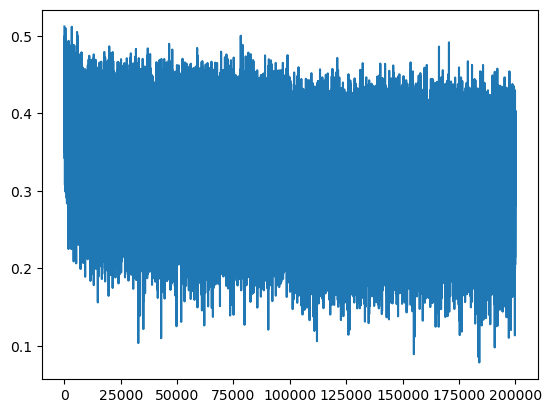

In [23]:
plt.plot(lossi)

In [24]:
h

tensor([[-1.0000,  0.5718,  0.9747,  ..., -0.1912,  0.9991, -0.5912],
        [ 0.6163,  0.0245, -0.3773,  ...,  0.3199,  0.4108, -0.0604],
        [-0.9955, -0.9894, -0.9384,  ...,  0.4767,  0.9608, -0.9997],
        ...,
        [ 0.8927, -0.6360, -0.2515,  ...,  0.8467,  0.7182,  0.5196],
        [-0.9521, -0.9995,  0.9501,  ..., -0.9686,  0.9999,  0.8767],
        [ 0.2177, -0.9923, -0.9698,  ..., -0.9581,  0.9998, -0.9755]],
       grad_fn=<TanhBackward0>)

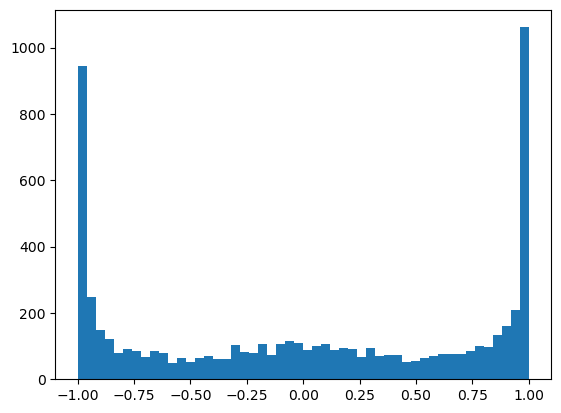

In [25]:
plt.hist(h.view(-1).tolist(),50);

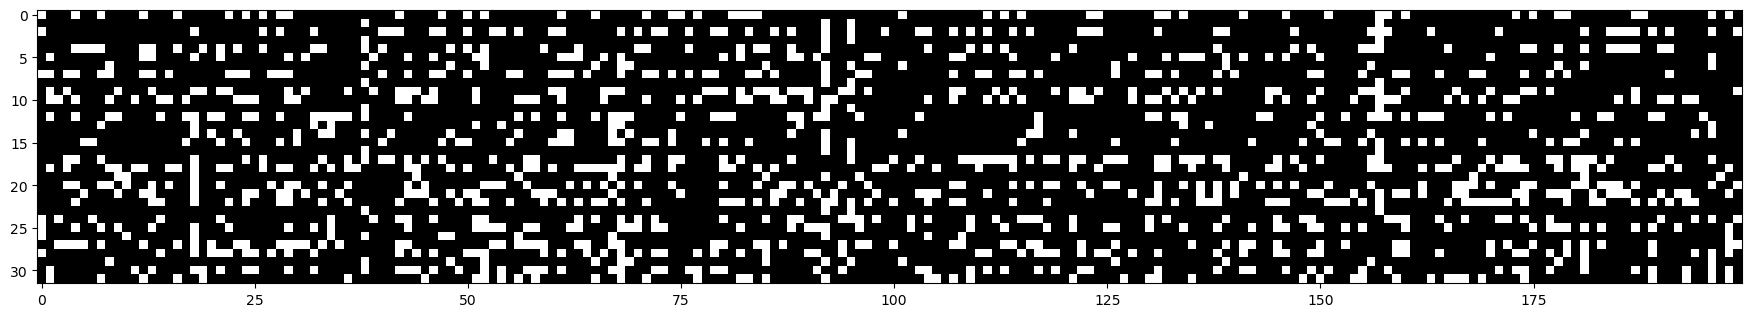

In [26]:
plt.figure(figsize=(22,11))
plt.imshow(h.abs()>0.99,cmap='gray', interpolation = 'nearest')

In [27]:
@torch.no_grad()
def split_loss(split):
    x,y = {
		'train': {Xtr, Ytr},
		'val': {Xdev, Ydev},
		'test': {Xte, Yte}
	}[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h  = torch.tanh(embcat @ W1 +b1)
    logits = h@W2 +b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0412237644195557
val 2.1081442832946777
